New Model 


Import Libraries

In [3]:
import pandas as pd
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torchvision import models
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from typing_extensions import dataclass_transform
import random
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)

In [4]:
class SkinData:
  def __init__(self, root, transform = True, train = True):
      if train:
        data_folder = 'balanced_dataset/'

      else:
        data_folder = 'Validation_Image/'

      data_dirs = os.listdir(os.path.join(root,data_folder))
      self.data_files = []
      self.labels = []
      label = 0
      for dir in data_dirs:
        path_name = os.path.join(root,data_folder,dir)
        data_samples = [os.path.join(path_name, fname) for fname in os.listdir(path_name)]
        label_samples = label * np.ones(len(data_samples))
        print(dir)
        print(len(label_samples))
        self.data_files.extend(data_samples)
        self.labels.extend(label_samples)
        self.transform = transform

        label += 1

  def __len__(self):
    return len(self.data_files)

  def __getitem__(self, index):
    new_width = 256
    new_height = 256
    data_file = self.data_files[index]
    image = np.array(cv2.imread(data_file))
    label = np.array(self.labels[index])

    data_sample = cv2.resize(image, (new_width, new_height))
    resize_data = np.array(data_sample)

    if self.transform:
      data_sample = torch.from_numpy(data_sample)
      lable = torch.from_numpy(label)

    data_point = {'data_sample': data_sample, 'lable':lable}

    return data_point

Create dataset and data loaders

In [5]:
root = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer'
dataset = SkinData(root, transform=True, train= True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loder = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loder = DataLoader(test_dataset, batch_size=8, shuffle=False)

test_dataset = SkinData(root, transform=True, train = False)

dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)

akiec
1244
bcc
1464
bkl
1044
df
1308
mel
1057
nv
1302
vasc
1350
akiec
16
bcc
26
bkl
55
df
6
mel
56
nv
335
vasc
7


In [6]:
len(train_dataset)

7015

Data Visualization

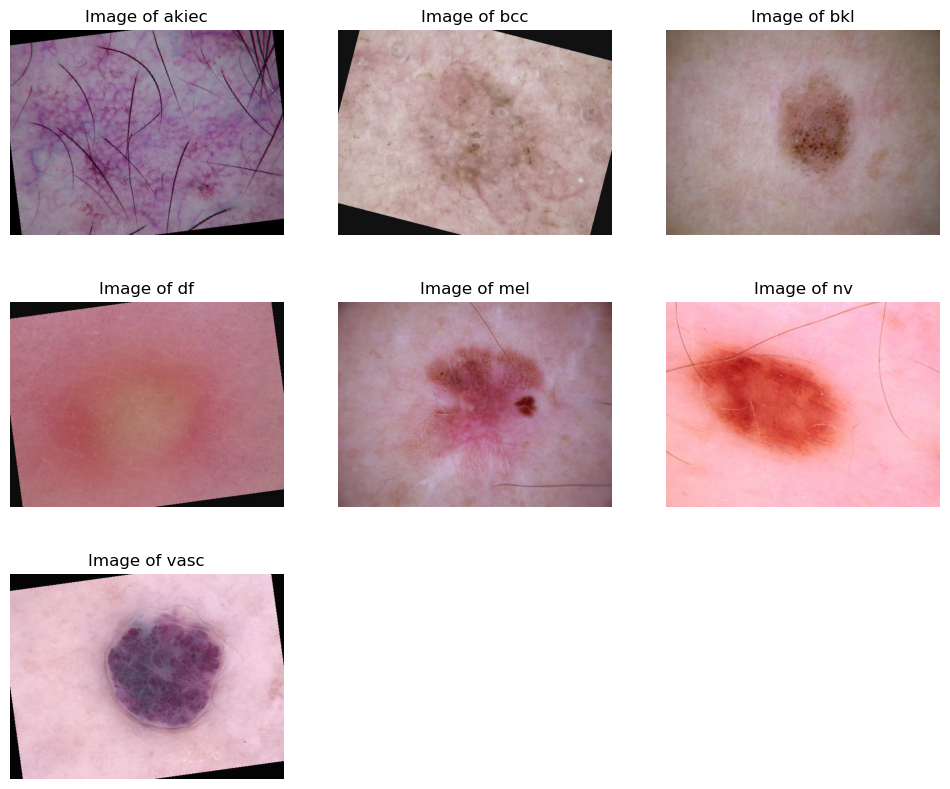

In [7]:
# Data Visualization
# Define the directory path for the training images
train_images_dir = r"C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Balanced_dataset"

top_n = 20  # Variable for top-n random images to select from.
image_sample = []  # List containing array of images.
image_sample_category = []  # List containing image type

# Make sure train_images_dir is correctly defined before this loop
for sub_dir in os.scandir(train_images_dir):
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = []  # List of top n images from current sub-dir.

    # Ensure we handle cases where there are fewer than top_n images
    num_images = min(len(images_paths), top_n)

    # Appending up to top_n images from the current sub-dir
    for image_path in images_paths[:num_images]:
        current_dir_img_paths.append(image_path)

    # Select a random image from the current directory
    if current_dir_img_paths:
        selected_image = random.choice(current_dir_img_paths)  # Selecting random image from the list
        image = cv2.imread(selected_image)  # Reading the image

        if image is not None:
            image = image[:, :, ::-1]  # Converting BGR to RGB
            image_sample_category.append(sub_dir.name)  # Append image category (cancer type)
            image_sample.append(image)  # Append the image array to the list
        else:
            print(f"Warning: Could not read image {selected_image}")
    else:
        print(f"No images found in directory {sub_dir.name}")

# Plotting the selected random images
plt.figure(figsize=(12, 10))
for num in range(len(image_sample)):
    plt.subplot(3, 3, num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}")
    plt.imshow(image_sample[num])

plt.show()

tensor(0., dtype=torch.float64)


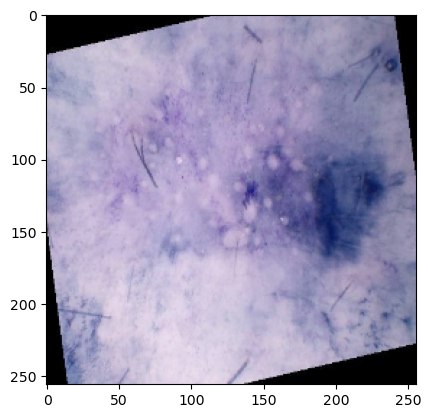

In [8]:
plt.imshow(train_dataset[1000]['data_sample'])
print(train_dataset[1000]['lable'])

In [9]:
train_dataset[1000]['data_sample'].shape

torch.Size([256, 256, 3])

Define the New model for skin cancer classification

In [ ]:
# Model Definition
class NewCNNNet(nn.Module):
    def __init__(self):
        super(NewCNNNet, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512
            
            nn.Flatten(),  # Flatten the 8x8x512 to a vector
            nn.Linear(8 * 8 * 512, 1024, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),  # Dropout to reduce overfitting
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 128, bias=True),
            nn.ReLU(True),
            nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        out = self.main(x)
        return out

Initialize the model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
net = NewCNNNet().to(device)

In [15]:
print(torch.cuda.get_device_name(0))  # To check your GPU device name
print(torch.cuda.is_available())  # To confirm GPU is available

NVIDIA GeForce RTX 3050 Laptop GPU
True


In [16]:
import torch.optim as optim
# Print the network architecture
print(net)
# Optimizer: Adamax
optimizer = optim.Adamax(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Loss function

# Example: Suppose you have 7 classes with these sample counts
class_counts = torch.tensor([1244, 1464, 1044, 1308, 1057, 1302, 1350], dtype=torch.float32)

# Compute weights (inverse of class frequencies)
class_weights = 1.0 / class_counts  
class_weights /= class_weights.sum()  # Normalize to sum to 1

# Move weights to device (if using GPU)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

ImprovedCNNNet(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(2

In [17]:
len(dataloader_train)

439

Training setup

In [25]:
# Lists to store average losses and accuracies per epoch
avg_train_loss_list = []
avg_val_loss_list = []
train_acc_list = []
val_acc_list = []
true_labels = []
predicted_labels = []
predicted_probs = []

# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\New'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer,filename=checkpoint_path)

# Training Loop
for epoch in range(start_epoch,start_epoch+20):  # Now starts from the saved epoch
    accuracy = 0
    val_accuracy = 0
    running_loss = 0.0
    val_running_loss = 0.0
    num_batches_train = len(dataloader_train)
    num_batches_val = len(dataloader_val)

    # Training loop
    for i, data in enumerate(dataloader_train, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        loss = criterion(prediction, encoded_labels.float())
        running_loss += loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        accuracy += sum(predicted_class == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('epoch:', epoch, 'loss:', loss.item())

    avg_train_loss = running_loss / num_batches_train
    avg_train_loss_list.append(avg_train_loss)

    # Validation loop
    for i, data in enumerate(dataloader_val, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        val_loss = criterion(prediction, encoded_labels.float())
        val_running_loss += val_loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        val_accuracy += sum(predicted_class == labels)

        # Store true and predicted labels for metrics
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted_class.cpu().numpy())
        predicted_probs.extend(F.softmax(prediction, dim=1).cpu().detach().numpy())  # For ROC/AUC

    avg_val_loss = val_running_loss / num_batches_val
    avg_val_loss_list.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

    accuracy = accuracy.cpu().numpy()
    train_acc_list.append(accuracy / train_dataset.__len__() * 100)
    val_accuracy = val_accuracy.cpu().numpy()
    val_acc_list.append(val_accuracy / val_dataset.__len__() * 100)

    scheduler.step()

    # Save model checkpoint after each epoch
    torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss.item(),
}, os.path.join(save_dir, 'latest_checkpoint.pth'), _use_new_zipfile_serialization=False)


    print(f'Model saved after epoch {epoch}')
    print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

    # After each epoch, save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': [epoch],
        'Train Accuracy': [train_acc_list[-1]],
        'Validation Accuracy': [val_acc_list[-1]],
        'Average Train Loss': [avg_train_loss],
        'Average Validation Loss': [avg_val_loss]
    })

    metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), mode='a', index=False, header=not os.path.exists(os.path.join(save_dir, 'training_metrics.csv')))
    print("Epoch metrics saved to training_metrics.csv")

Loading checkpoint 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\New\latest_checkpoint.pth'


C:\Users\vindu\AppData\Local\Temp\ipykernel_22868\4155342139.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Resuming from epoch 20
epoch: 20 loss: 0.10344208776950836
epoch: 20 loss: 0.10326331108808517
epoch: 20 loss: 0.10086162388324738
epoch: 20 loss: 0.07948523759841919
epoch: 20 loss: 0.11950667202472687
epoch: 20 loss: 0.07278300821781158
epoch: 20 loss: 0.12899473309516907
epoch: 20 loss: 0.09588459134101868
epoch: 20 loss: 0.09826156497001648
Epoch 20: Train Accuracy: 69.62%, Validation Accuracy: 62.20%
Model saved after epoch 20
Average Train Loss: 0.1082, Average Validation Loss: 0.1370
Epoch metrics saved to training_metrics.csv
epoch: 21 loss: 0.13574907183647156
epoch: 21 loss: 0.18181049823760986
epoch: 21 loss: 0.0635698139667511
epoch: 21 loss: 0.12784211337566376
epoch: 21 loss: 0.09587045013904572
epoch: 21 loss: 0.14433863759040833
epoch: 21 loss: 0.06317009031772614
epoch: 21 loss: 0.08509272336959839
epoch: 21 loss: 0.1470896601676941
Epoch 21: Train Accuracy: 69.59%, Validation Accuracy: 63.00%
Model saved after epoch 21
Average Train Loss: 0.1056, Average Validation Lo

Plot Average Losses

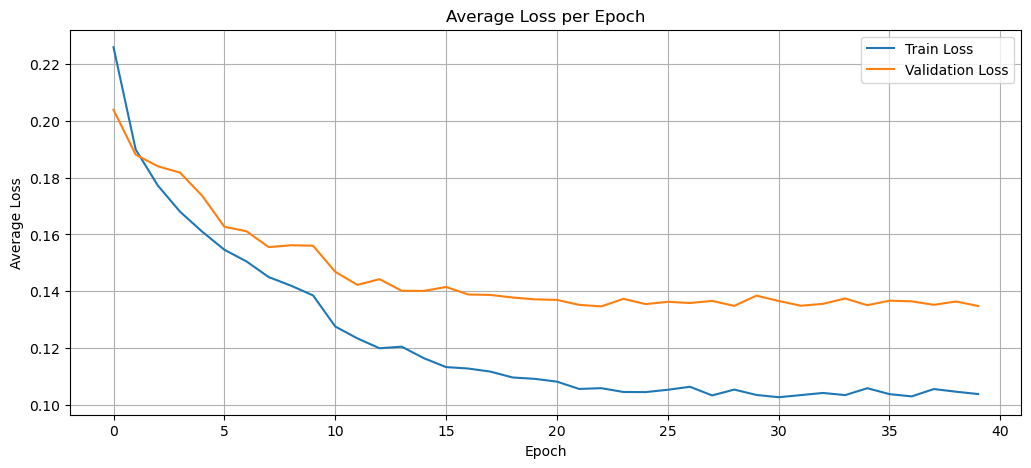

In [26]:
# Path to the CSV file
csv_file_path = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\New\training_metrics.csv'

# Load the metrics from the CSV file
metrics_df = pd.read_csv(csv_file_path)

# Plot Average Losses
plt.figure(figsize=(27, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(metrics_df['Epoch'], metrics_df['Average Train Loss'], label='Train Loss')
plt.plot(metrics_df['Epoch'], metrics_df['Average Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)

Plot Average Accuracies

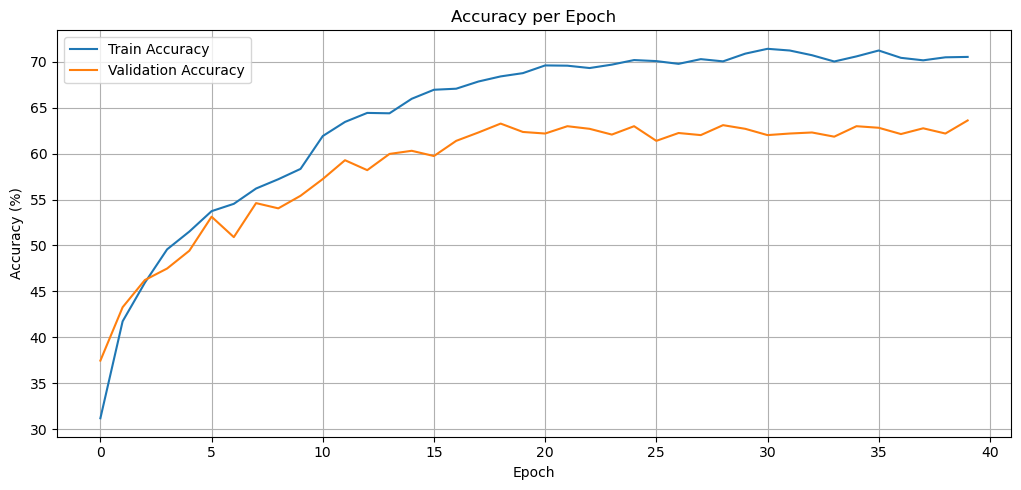

In [27]:
# Plot Accuracies
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

Function to load the latest checkpoint

In [28]:
# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\New'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, scheduler, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer, scheduler, filename=checkpoint_path)

# Training Loop

accuracy = 0
val_accuracy = 0
running_loss = 0.0
val_running_loss = 0.0
num_batches_train = len(dataloader_train)
num_batches_val = len(dataloader_val)

# Lists to store true and predicted labels for validation
true_labels = []
predicted_labels = []
predicted_probs = []

# Training loop
for i, data in enumerate(dataloader_train, 0):
    input = data['data_sample'].float().to(device)
    input = input.permute(0, 3, 1, 2)
    labels = data['lable'].to(device)
    encoded_labels = F.one_hot(labels.long(), num_classes=7)

    prediction = net(input)
    loss = criterion(prediction, encoded_labels.float())
    running_loss += loss.item()

    predicted_class = torch.argmax(prediction, dim=1)
    accuracy += sum(predicted_class == labels)

avg_train_loss = running_loss / num_batches_train

# Validation loop
for i, data in enumerate(dataloader_val, 0):
    input = data['data_sample'].float().to(device)
    input = input.permute(0, 3, 1, 2)
    labels = data['lable'].to(device)
    encoded_labels = F.one_hot(labels.long(), num_classes=7)

    prediction = net(input)
    val_loss = criterion(prediction, encoded_labels.float())
    val_running_loss += val_loss.item()

    predicted_class = torch.argmax(prediction, dim=1)
    val_accuracy += sum(predicted_class == labels)

    true_labels.extend(labels.cpu().numpy())  
    predicted_labels.extend(predicted_class.cpu().numpy()) 
    predicted_probs.extend(F.softmax(prediction, dim=1).cpu().detach().numpy())

avg_val_loss = val_running_loss / num_batches_val
avg_val_loss_list.append(avg_val_loss)


Loading checkpoint 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\New\latest_checkpoint.pth'


C:\Users\vindu\AppData\Local\Temp\ipykernel_22868\2932298796.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Resuming from epoch 40


Calculate Accuracy, F1 Score, Precision, Recall

In [29]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='macro')
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 62.60%
F1 Score: 0.6182
Precision: 0.6168
Recall: 0.6249


Plotting the confusion matrix

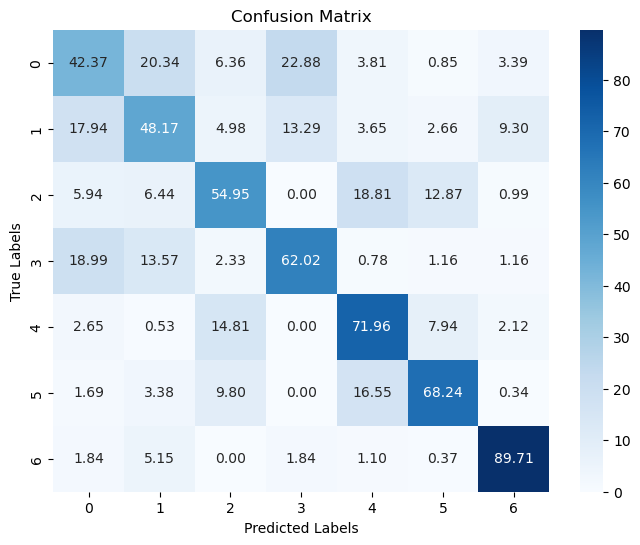

In [30]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Convert to percentage (normalize by row sum)
conf_matrix_percentage = conf_matrix.astype(np.float32)
conf_matrix_percentage /= conf_matrix_percentage.sum(axis=1, keepdims=True)  # Normalize each row
conf_matrix_percentage *= 100  # Convert to percentage

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

ROC Curve and AUC

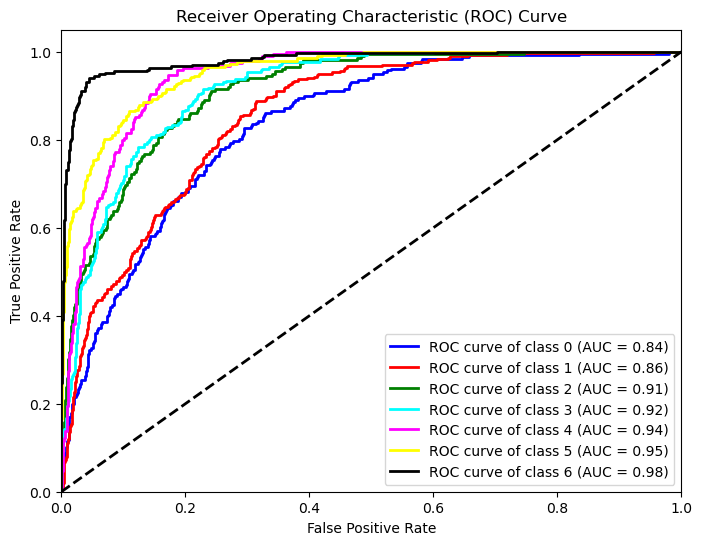

In [31]:
# ROC Curve and AUC
true_labels_bin = label_binarize(true_labels, classes=range(7))
predicted_probs = np.array(predicted_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()